In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Image loading and preprocessing
def load_image(path, max_size=400):
    image = Image.open(path).convert('RGB')
    size = min(max(image.size), max_size)
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

# Display image
def im_convert(tensor):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = transforms.ToPILImage()(image)
    return image

In [13]:
# Load images
content = load_image("monalisa.jpg")
style = load_image("Cubism.jpg")

# Use pre-trained VGG19 model
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Content and style layers
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Extract features
def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if f'conv_{name}' in layers:
            features[f'conv_{name}'] = x
    return features

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Gram matrix for style
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Extract features
content_features = get_features(content, vgg, content_layers)
style_features = get_features(style, vgg, style_layers)

# Compute Gram matrices for style features
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Target image
target = content.clone().requires_grad_(True).to(device)

# Optimizer
optimizer = optim.Adam([target], lr=0.003)

# Loss weights
style_weight = 1e6
content_weight = 1

for step in range(300):
    # Get new features from target
    target_features = get_features(target, vgg, style_layers + content_layers)

    # Content loss
    content_loss = torch.mean((target_features['conv_4'] - content_features['conv_4'].detach()) ** 2)

    # Style loss
    style_loss = 0
    for layer in style_layers:
        target_feat = target_features[layer]
        target_gram = gram_matrix(target_feat)
        style_gram = style_grams[layer].detach()  # ← detach from previous computation
        b, c, h, w = target_feat.shape
        style_loss += torch.mean((target_gram - style_gram)**2) / (c * h * w)

    total_loss = style_weight * style_loss + content_weight * content_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}, Total Loss: {total_loss.item()}")


Step 0, Total Loss: 107888066560.0
Step 50, Total Loss: 95933521920.0
Step 100, Total Loss: 75227758592.0
Step 150, Total Loss: 49614016512.0
Step 200, Total Loss: 27066980352.0
Step 250, Total Loss: 14533083136.0


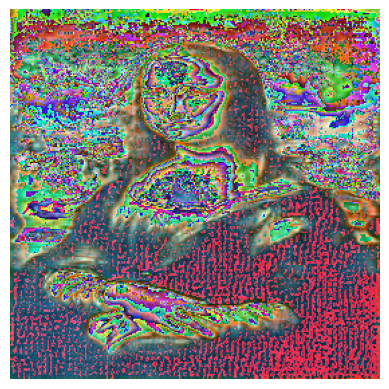

In [15]:
# Show result
final_img = im_convert(target)
plt.imshow(final_img)
plt.axis('off')
plt.show()